In [1]:
from functions_for_all_nutrients import *
from iron_hemoglobin_functions import *

In [2]:
location_ids = [179,
 163,
 214,
 161,
 165,
 190,
 189,
 196,
 201,
 180,
 15,
 164,
 20,
 202,
 205,
 171,
 11,
 184,
 168,
 6,
 141,
 207,
 181,
 213,
 522]

# Impact (DALYs averted)

In [3]:
folic_acid = pd.read_pickle('results_raw/folic_acid.pkl')

In [4]:
iron_u5 = pd.read_pickle('results_raw/iron_u5.pkl')
iron_wra = pd.read_pickle('results_raw/iron_wra.pkl')
iron_u5_industry = pd.read_pickle('results_raw/iron_u5_industry_wheat_update.pkl')
iron_wra_industry = pd.read_pickle('results_raw/iron_wra_industry_wheat_update.pkl')


In [5]:
iron_u5 = pd.read_pickle('results_raw/iron_u5.pkl')
iron_wra = pd.read_pickle('results_raw/iron_wra.pkl')
iron = (iron_u5.set_index([c for c in iron_u5.columns if 'draw' not in c])
        + iron_wra.set_index([c for c in iron_u5.columns if 'draw' not in c])).reset_index()
iron = iron.loc[iron.vehicle!='industry wheat'].loc[iron.vehicle!='zero industry wheat']
iron_u5_industry = pd.read_pickle('results_raw/iron_u5_industry_wheat_update.pkl')
iron_wra_industry = pd.read_pickle('results_raw/iron_wra_industry_wheat_update.pkl')
iron_industry = (iron_u5_industry.set_index([c for c in iron_u5_industry.columns if 'draw' not in c])
        + iron_wra_industry.set_index([c for c in iron_u5_industry.columns if 'draw' not in c])).reset_index()
iron = (pd.concat([iron, iron_industry], ignore_index=True)
        .set_index(['location_id','vehicle','coverage_level','year','measure'])
        .sort_index())
iron = iron.reset_index().loc[iron.reset_index().measure=='counts_averted']
iron['nutrient'] = 'iron'
iron.head()

draw,location_id,vehicle,coverage_level,year,measure,draw_0,draw_1,draw_10,draw_100,draw_101,...,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,nutrient
0,6,industry wheat,0.2,2025,counts_averted,46401.393556,17666.119865,16817.789856,15359.260594,42713.988206,...,23935.157418,65306.671924,57710.973892,15211.242086,28157.281503,46928.570617,18965.379860,21516.484731,22514.522374,iron
3,6,industry wheat,0.5,2025,counts_averted,111953.765398,43615.161267,41439.833172,37978.480348,103655.815155,...,58768.564088,157709.328953,138915.827879,37643.277170,68791.794238,113479.714207,46868.471701,52948.774827,55586.155959,iron
6,6,industry wheat,0.8,2025,counts_averted,172926.521156,68917.389955,65353.862357,60102.932143,161017.484255,...,92356.162018,243797.527960,214071.100552,59620.898089,107577.903514,175667.558101,74129.248238,83395.594837,87833.984654,iron
9,6,industry wheat,1.0,2025,counts_averted,211180.374835,85433.523539,80912.794261,74582.553818,197364.086006,...,114076.159502,297872.692890,261019.253394,74024.254771,132448.054029,214834.251621,91952.671261,103159.905824,108883.862818,iron
12,6,wheat flour,0.2,2025,counts_averted,46505.884893,16382.039118,18063.177350,16308.587421,51206.050559,...,27641.636990,76512.392640,63279.662641,13726.681998,31464.260830,57438.837049,17464.722476,25264.156256,24978.217913,iron


In [6]:
vehicles = ['zero maize flour', 'maize flour', 'zero industry wheat',
       'industry wheat', 'zero wheat flour', 'wheat flour',
       'zero industry salt', 'industry salt', 'zero salt', 'salt',
           'oil','industry oil','zero oil','zero industry oil']

In [7]:
vitamin_a_no_oil = pd.read_pickle('results_raw/vitamin_a.pkl')
vitamin_a_no_oil = vitamin_a_no_oil.loc[vitamin_a_no_oil.vehicle.isin([v for v in vehicles if 'oil' not in v])]
vitamin_a_oil = pd.read_pickle('results_raw/vitamin_a_oil_update.pkl')
vitamin_a = pd.concat([vitamin_a_no_oil, vitamin_a_oil], ignore_index=True)
vitamin_a['nutrient'] = 'vitamin a'
vitamin_a.head()

draws,location_id,year,vehicle,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,...,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,measure,nutrient
0,6,2021,industry wheat,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,vitamin a
1,6,2021,industry wheat,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,vitamin a
2,6,2021,industry wheat,0.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,vitamin a
3,6,2021,industry wheat,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,vitamin a
4,6,2021,wheat flour,0.2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pif,vitamin a


In [8]:
zinc = pd.read_pickle('results_raw/zinc.pkl')
zinc['nutrient'] = 'zinc'
zinc_prev = pd.read_pickle('results_raw/zinc_deficiency_exposure.pkl')
zinc_prev['measure'] = 'deficiency_exposure'

#vitamin_a = pd.read_pickle('results_raw/vitamin_a.pkl')
#vitamin_a['nutrient'] = 'vitamin a'
#vitamin_a_prev = pd.read_pickle('results_raw/vitamin_a_deficiency_exposure.pkl')
#vitamin_a_prev['measure'] = 'deficiency_exposure'

results = pd.concat([folic_acid.rename(columns={'year_id':'year'}), 
                     zinc, vitamin_a, iron], ignore_index=True, sort=True)
#results['nutrient'] = results.nutrient.str.replace('vitamin a','vitamin A')
#results['nutrient_name'] = results.nutrient.str.replace('_',' ').str.capitalize().str.replace('Vitamin a', 'Vitamin A')
l = get_ids('location')[['location_name','location_id']]
results = results.merge(l, on='location_id')
#results['label'] = results.nutrient_name + ' in ' + results.vehicle
results = results.loc[results.year==2025].loc[results.measure=='counts_averted']
results.head()

,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,draw_996,draw_997,draw_998,draw_999,location_id,measure,nutrient,vehicle,year,location_name
9,0.2,743.496800,1479.550469,1597.952786,1083.064738,488.736716,673.982572,510.457605,647.465561,1212.476363,...,977.907162,1099.670404,1693.312600,1520.486189,141,counts_averted,folic acid,maize flour,2025,Egypt
10,0.5,1858.742000,3698.876173,3994.881966,2707.661845,1221.841789,1684.956430,1276.144012,1618.663902,3031.190907,...,2444.767905,2749.176009,4233.281499,3801.215472,141,counts_averted,folic acid,maize flour,2025,Egypt
11,0.8,2973.987200,5918.201877,6391.811146,4332.258952,1954.946863,2695.930288,2041.830419,2589.862243,4849.905452,...,3911.628649,4398.681615,6773.250399,6081.944755,141,counts_averted,folic acid,maize flour,2025,Egypt
21,0.2,1016.927577,1620.764474,2355.507146,2885.105359,897.596800,1118.381023,866.496853,757.477571,2210.746638,...,2089.723743,1427.178321,2244.898758,1551.782277,141,counts_averted,folic acid,wheat flour,2025,Egypt
22,0.5,2542.318942,4051.911185,5888.767865,7212.763397,2243.992000,2795.952558,2166.242132,1893.693927,5526.866595,...,5224.309357,3567.945802,5612.246894,3879.455694,141,counts_averted,folic acid,wheat flour,2025,Egypt


In [9]:
wheat_locs = list(results.loc[results.vehicle=='wheat flour']
                  .loc[results.location_id!=1]
                  .loc[results.location_id!=2]
                  .location_id.unique())
oil_locs = list(results.loc[results.vehicle=='oil']
                  .loc[results.location_id!=1]
                  .loc[results.location_id!=2]
                  .location_id.unique())
maize_locs = list(results.loc[results.vehicle=='maize flour']
                  .loc[results.location_id!=1]
                  .loc[results.location_id!=2]
                  .location_id.unique())
salt_locs = list(results.loc[results.vehicle=='salt']
                  .loc[results.location_id!=1]
                  .loc[results.location_id!=2]
                  .location_id.unique())

In [10]:
results_global = results.groupby([c for c in results.columns if 'draw' not in c and c not in ['location_id','location_name']]).sum().reset_index()
results_global['location_id'] = 1.5
results_global['location_name'] = 'All locations'
results = pd.concat([results, results_global], ignore_index=True, sort=True)

focus_locs = [214,179,163]
location_groups = [focus_locs, wheat_locs, oil_locs, maize_locs, salt_locs]
location_group_ids = [2.5, 3.5, 4.5, 5.5, 6.5]
location_group_names = ['Nigeria, Ethiopia, and India combined',
                       'Wheat flour locations',
                       'Oil locations',
                       'Maize flour locations',
                       'Salt locations']

for i in list(range(0,len(location_groups))):
    results_focus = (results.loc[results.location_id.isin(location_groups[i])]
                 .groupby([c for c in results.columns if 'draw' not in c and c not in ['location_id','location_name']])
                 .sum().reset_index())
    results_focus['location_id'] = location_group_ids[i]
    results_focus['location_name'] = location_group_names[i]
    results = pd.concat([results, results_focus], ignore_index=True, sort=True)

results_all_nutrients = results.groupby([c for c in results.columns if 'draw' not in c and c != 'nutrient']).sum().reset_index()
results_all_nutrients['nutrient'] = 'all'
results = pd.concat([results, results_all_nutrients], ignore_index=True, sort=True)#.drop(columns='index')

results.head()

,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,draw_996,draw_997,draw_998,draw_999,location_id,location_name,measure,nutrient,vehicle,year
0,0.2,743.496800,1479.550469,1597.952786,1083.064738,488.736716,673.982572,510.457605,647.465561,1212.476363,...,977.907162,1099.670404,1693.312600,1520.486189,141.0,Egypt,counts_averted,folic acid,maize flour,2025.0
1,0.5,1858.742000,3698.876173,3994.881966,2707.661845,1221.841789,1684.956430,1276.144012,1618.663902,3031.190907,...,2444.767905,2749.176009,4233.281499,3801.215472,141.0,Egypt,counts_averted,folic acid,maize flour,2025.0
2,0.8,2973.987200,5918.201877,6391.811146,4332.258952,1954.946863,2695.930288,2041.830419,2589.862243,4849.905452,...,3911.628649,4398.681615,6773.250399,6081.944755,141.0,Egypt,counts_averted,folic acid,maize flour,2025.0
3,0.2,1016.927577,1620.764474,2355.507146,2885.105359,897.596800,1118.381023,866.496853,757.477571,2210.746638,...,2089.723743,1427.178321,2244.898758,1551.782277,141.0,Egypt,counts_averted,folic acid,wheat flour,2025.0
4,0.5,2542.318942,4051.911185,5888.767865,7212.763397,2243.992000,2795.952558,2166.242132,1893.693927,5526.866595,...,5224.309357,3567.945802,5612.246894,3879.455694,141.0,Egypt,counts_averted,folic acid,wheat flour,2025.0


# Micronutrient deficiency attributable DALYs (total burden envelope)

In [11]:
gbd_data_directory = '/share/scratch/users/ndbs/vivarium_lsff/gbd_data'
gbd_data_filepath = f'{gbd_data_directory}/multmodel_data.hdf'
vitamin_a_dalys_hdf_key = '/vitamin_a_deficiency/dalys_attributable_bmgf_25_countries'
zinc_dalys_hdf_key = '/zinc_deficiency/dalys_attributable_bmgf_25_countries'

In [12]:
ira_dalys_u5 = pd.read_pickle('results_raw/u5_ira_dalys.pkl')
ira_dalys_wra = pd.read_pickle('results_raw/wra_ira_dalys.pkl')
maternal_dalys = pd.read_pickle('results_raw/iron_maternal_dalys.pkl')

iron_dalys = (ira_dalys_u5 + ira_dalys_wra + maternal_dalys).reset_index()
iron_dalys['nutrient'] = 'iron'
vitamin_a_dalys = pd.read_hdf(gbd_data_filepath, key=vitamin_a_dalys_hdf_key).groupby('location_id').sum().reset_index()
vitamin_a_dalys['nutrient'] = 'vitamin a'
zinc_dalys = pd.read_hdf(gbd_data_filepath, key=zinc_dalys_hdf_key).groupby('location_id').sum().reset_index()
zinc_dalys['nutrient'] = 'zinc'
fa_dalys = pd.read_pickle('results_raw/folic_acid_dalys').groupby('location_id').sum().reset_index()
fa_dalys['nutrient'] = 'folic acid'

mn_dalys_by_location = pd.concat([iron_dalys,vitamin_a_dalys,zinc_dalys,fa_dalys], ignore_index=True)
mn_dalys_by_location = mn_dalys_by_location.merge(l.filter(['location_id','location_name']), on='location_id')

mn_dalys_tot = mn_dalys_by_location.groupby(['nutrient']).sum().reset_index()
mn_dalys_tot['location_id'] = 1.5
mn_dalys_tot['location_name'] = 'All locations'
mn_dalys = pd.concat([mn_dalys_by_location, mn_dalys_tot], ignore_index=True, sort=True)


for i in list(range(0,len(location_groups))):
    mn_dalys_focus = (mn_dalys.loc[mn_dalys.location_id.isin(location_groups[i])]
                 .groupby([c for c in mn_dalys.columns if 'draw' not in c and c not in ['location_id','location_name']])
                 .sum().reset_index())
    mn_dalys_focus['location_id'] = location_group_ids[i]
    mn_dalys_focus['location_name'] = location_group_names[i]
    mn_dalys = pd.concat([mn_dalys, mn_dalys_focus], ignore_index=True, sort=True)

mn_dalys_all_nutrients = mn_dalys.groupby(['location_id','location_name']).sum().reset_index()
mn_dalys_all_nutrients['nutrient'] = 'all'

mn_dalys = pd.concat([mn_dalys, mn_dalys_all_nutrients], ignore_index=True, sort=True)

mn_dalys.head()

,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,draw_106,...,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,location_id,location_name,nutrient
0,1.088341e+06,1.092373e+06,762827.738394,1.088802e+06,918395.054720,1.059648e+06,1.023009e+06,1.036586e+06,1.429627e+06,744071.932942,...,1.015310e+06,1.068034e+06,951715.641645,531755.419221,991216.364213,807446.968604,1.029708e+06,6.0,China,iron
1,1.454350e+04,1.197750e+04,11448.426442,1.239985e+04,8144.108069,7.788482e+03,1.269808e+04,1.159036e+04,1.293447e+04,12179.264153,...,1.392708e+04,1.501954e+04,14154.575077,5733.640120,9042.731785,10284.961592,1.306504e+04,6.0,China,vitamin a
2,9.334932e+01,0.000000e+00,50.992349,1.771175e+02,83.794119,5.429564e+01,2.054217e+01,7.267064e+01,2.667262e+02,46.635706,...,2.616231e+02,4.159172e+02,320.074090,114.299721,67.262926,141.217649,2.784588e+02,6.0,China,zinc
3,2.492471e+05,2.374986e+05,227375.754611,2.328436e+05,267015.627168,2.189806e+05,2.477495e+05,2.608663e+05,2.256746e+05,202430.202541,...,2.914886e+05,2.378309e+05,258073.242836,226426.412747,313207.120505,212017.306296,2.449056e+05,6.0,China,folic acid
4,8.064069e+05,7.199461e+05,572539.557797,7.363103e+05,558856.983018,6.408518e+05,7.047883e+05,5.449609e+05,7.465499e+05,482070.153037,...,6.151569e+05,6.481918e+05,655928.444989,369832.379076,485029.011237,469226.367635,5.812303e+05,11.0,Indonesia,iron


# PIFs

In [13]:
pifs = (results.loc[results.measure=='counts_averted'].set_index(['location_id','location_name','nutrient','vehicle','coverage_level']).drop(columns=['measure','year'])
 / mn_dalys.set_index(['location_id','location_name','nutrient']) * 100).reset_index()#.mean(axis=1).reset_index()
pifs.head()

,location_id,location_name,nutrient,coverage_level,vehicle,draw_0,draw_1,draw_10,draw_100,draw_101,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,1.5,All locations,all,0.2,industry oil,0.496253,0.341487,0.203574,0.223969,0.173492,...,0.152669,0.287534,0.565357,0.583547,0.269180,0.209813,0.349633,0.219944,0.189041,0.109535
1,1.5,All locations,all,0.2,industry wheat,1.798629,0.986885,0.896991,0.639485,1.491570,...,1.005699,0.868277,1.996810,2.202809,0.929777,1.031197,2.231160,0.921124,0.872018,0.727325
2,1.5,All locations,all,0.2,maize flour,0.466962,0.246064,0.279388,0.224189,0.367199,...,0.363076,0.262508,0.425160,0.543200,0.236179,0.309739,0.541382,0.335469,0.306467,0.299316
3,1.5,All locations,all,0.2,oil,0.440854,0.273785,0.159376,0.166993,0.153079,...,0.122247,0.221709,0.466815,0.480986,0.218507,0.165001,0.260899,0.157996,0.148649,0.091537
4,1.5,All locations,all,0.2,wheat flour,1.640762,0.825972,0.826044,0.699250,1.336138,...,1.139517,0.852761,1.648066,1.766350,0.907157,1.104962,2.137649,0.978358,1.067597,0.981400


In [14]:
rsum = pifs.loc[pifs.coverage_level==0.8]
rsum = (rsum.set_index([c for c in rsum.columns if 'draw' not in c])
        .apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
        .filter(['mean','2.5%','97.5%'])
        .rename(columns={'2.5%':'lower','97.5%':'upper','mean':'mean_val'})
        .reset_index())
for col in ['mean_val','lower','upper']:
    rsum[f'{col}'] = rsum[f'{col}'].map('{:.2f}'.format)
rsum['value'] = (rsum['mean_val'].astype(str)
                                        +' ('
                                        +rsum['lower'].astype(str)
                                        +', '
                                        +rsum['upper'].astype(str)
                                        +')')
rsum['nutrient'] = rsum.nutrient.str.capitalize()
rsum['nutrient'] = rsum.nutrient.str.replace('Vitamin a','Vitamin A')
rsum = (rsum.pivot_table(index=['location_name','vehicle'], 
                         columns=['nutrient'], 
                         values='value', 
                         aggfunc=lambda x: ' '.join(x))
        .replace(np.nan, 'Not modeled')
        .reset_index())
rsum.head()

nutrient,location_name,vehicle,All,Folic acid,Iron,Vitamin A,Zinc
0,All locations,industry oil,"1.16 (-0.06, 2.62)",Not modeled,Not modeled,"16.55 (-1.25, 28.70)",Not modeled
1,All locations,industry wheat,"4.65 (0.16, 9.71)",Not modeled,"5.62 (0.07, 12.29)","8.01 (-0.55, 13.72)","14.48 (8.33, 20.76)"
2,All locations,maize flour,"1.24 (0.30, 2.19)","2.07 (1.39, 2.86)","0.87 (0.01, 1.86)","2.49 (-0.14, 4.30)","2.05 (0.97, 3.14)"
3,All locations,oil,"0.91 (-0.05, 2.02)",Not modeled,Not modeled,"12.92 (-0.94, 23.25)",Not modeled
4,All locations,wheat flour,"4.37 (0.97, 7.83)","6.71 (4.79, 8.61)","3.45 (0.04, 7.34)","6.25 (-0.34, 10.51)","10.53 (5.72, 15.30)"


# Results viz

In [15]:
pifs.head()

,location_id,location_name,nutrient,coverage_level,vehicle,draw_0,draw_1,draw_10,draw_100,draw_101,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,1.5,All locations,all,0.2,industry oil,0.496253,0.341487,0.203574,0.223969,0.173492,...,0.152669,0.287534,0.565357,0.583547,0.269180,0.209813,0.349633,0.219944,0.189041,0.109535
1,1.5,All locations,all,0.2,industry wheat,1.798629,0.986885,0.896991,0.639485,1.491570,...,1.005699,0.868277,1.996810,2.202809,0.929777,1.031197,2.231160,0.921124,0.872018,0.727325
2,1.5,All locations,all,0.2,maize flour,0.466962,0.246064,0.279388,0.224189,0.367199,...,0.363076,0.262508,0.425160,0.543200,0.236179,0.309739,0.541382,0.335469,0.306467,0.299316
3,1.5,All locations,all,0.2,oil,0.440854,0.273785,0.159376,0.166993,0.153079,...,0.122247,0.221709,0.466815,0.480986,0.218507,0.165001,0.260899,0.157996,0.148649,0.091537
4,1.5,All locations,all,0.2,wheat flour,1.640762,0.825972,0.826044,0.699250,1.336138,...,1.139517,0.852761,1.648066,1.766350,0.907157,1.104962,2.137649,0.978358,1.067597,0.981400


In [16]:
p = (results.loc[results.nutrient=='all']
     .set_index([c for c in results.columns if 'draw' not in c])
     .mean(axis=1).rename(columns={0:'mean'}).reset_index())
p

,coverage_level,location_id,location_name,measure,nutrient,vehicle,year,0
0,0.2,1.5,All locations,counts_averted,all,industry oil,2025.0,71077.639158
1,0.2,1.5,All locations,counts_averted,all,industry wheat,2025.0,285052.646423
2,0.2,1.5,All locations,counts_averted,all,maize flour,2025.0,75573.198573
3,0.2,1.5,All locations,counts_averted,all,oil,2025.0,55327.995663
4,0.2,1.5,All locations,counts_averted,all,wheat flour,2025.0,267415.138912
...,...,...,...,...,...,...,...,...
1127,1.0,522.0,Sudan,counts_averted,all,zero industry oil,2025.0,-11625.485880
1128,1.0,522.0,Sudan,counts_averted,all,zero industry wheat,2025.0,-4076.560045
1129,1.0,522.0,Sudan,counts_averted,all,zero maize flour,2025.0,-3567.494197
1130,1.0,522.0,Sudan,counts_averted,all,zero oil,2025.0,-11625.485880


([<matplotlib.axis.XTick at 0x2b4b716df2b0>,
 [Text(0.0, 0, 'Industry Wheat Flour'),
  Text(0.22, 0, 'Wheat Flour'),
  Text(0.44000000000000006, 0, 'Maize Flour'),
  Text(0.6600000000000001, 0, 'Industry Oil'),
  Text(0.8800000000000001, 0, 'Oil')])

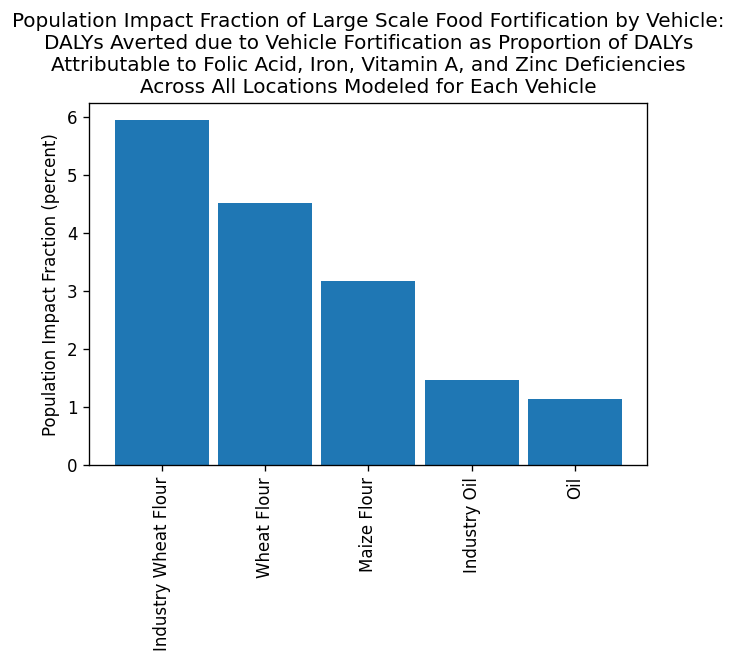

In [17]:
# GLOBAL PIF BY VEHICLE FOR ALL LOCATIONS MODELED FOR EACH VEHICLE

p = (pifs.loc[pifs.nutrient=='all']
     .set_index([c for c in pifs.columns if 'draw' not in c])
     .mean(axis=1).rename(columns={0:'mean'}).reset_index())

wheat = p.loc[p.vehicle=='wheat flour'].loc[p.location_name=='Wheat flour locations']
industry_wheat = p.loc[p.vehicle=='industry wheat'].loc[p.location_name=='Wheat flour locations']
maize = p.loc[p.vehicle=='maize flour'].loc[p.location_name=='Maize flour locations']
oil = p.loc[p.vehicle=='oil'].loc[p.location_name=='Oil locations']
industry_oil = p.loc[p.vehicle=='industry oil'].loc[p.location_name=='Oil locations']
f, ax = plt.subplots(dpi=120)
barWidth = 0.20
spacerWidth = barWidth / 10
a1 = np.arange(1)
a = [x + barWidth + spacerWidth for x in a1]
b = [x + barWidth + spacerWidth for x in a]
c = [x + barWidth + spacerWidth for x in b]
d = [x + barWidth + spacerWidth for x in c]

plt.bar(a1, industry_wheat[0].values, 
        width=barWidth, 
        color = 'tab:blue',
       label='Industry wheat flour')
plt.bar(a, wheat[0].values, 
        width=barWidth, 
        color = 'tab:blue',
       label='Wheat flour')
plt.bar(b, maize[0], 
        width=barWidth, 
        color = 'tab:blue',
       label='Maize flour')
plt.bar(c, industry_oil[0], 
        width=barWidth, 
        color = 'tab:blue',
       label='Industry oil')
plt.bar(d, oil[0], 
        width=barWidth, 
        color = 'tab:blue',
       label='Oil')
plt.ylabel('Population Impact Fraction (percent)')
#plt.ylim(0,5)
plt.title('Population Impact Fraction of Large Scale Food Fortification by Vehicle:\nDALYs Averted due to Vehicle Fortification as Proportion of DALYs\nAttributable to Folic Acid, Iron, Vitamin A, and Zinc Deficiencies\nAcross All Locations Modeled for Each Vehicle')
plt.xticks([a1[0], a[0], b[0], c[0], d[0]], ['Industry Wheat Flour','Wheat Flour','Maize Flour','Industry Oil','Oil'], rotation=90)

([<matplotlib.axis.XTick at 0x2b4b71b43b38>,
 [Text(0.0, 0, 'Industry Wheat Flour'),
  Text(0.22, 0, 'Wheat Flour'),
  Text(0.44000000000000006, 0, 'Maize Flour'),
  Text(0.6600000000000001, 0, 'Industry Oil'),
  Text(0.8800000000000001, 0, 'Oil')])

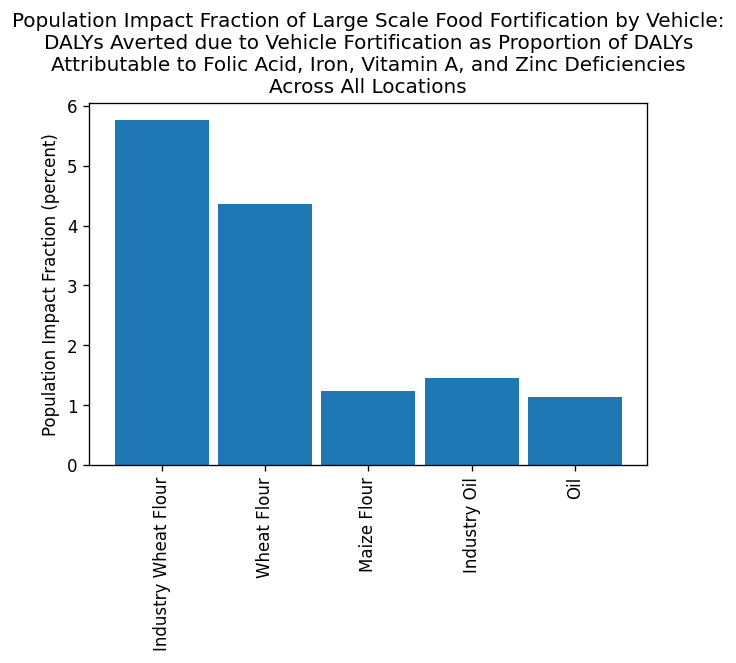

In [18]:
# GLOBAL PIF BY VEHICLE FOR ALL LOCATIONS MODELED FOR EACH VEHICLE

p = (pifs.loc[pifs.nutrient=='all']
     .loc[pifs.location_name=='All locations']
     .set_index([c for c in pifs.columns if 'draw' not in c])
     .mean(axis=1).rename(columns={0:'mean'}).reset_index())

wheat = p.loc[p.vehicle=='wheat flour']#.loc[p.location_name=='Wheat flour locations']
industry_wheat = p.loc[p.vehicle=='industry wheat']#.loc[p.location_name=='Wheat flour locations']
maize = p.loc[p.vehicle=='maize flour']#.loc[p.location_name=='Maize flour locations']
oil = p.loc[p.vehicle=='oil']#.loc[p.location_name=='Oil locations']
industry_oil = p.loc[p.vehicle=='industry oil']#.loc[p.location_name=='Oil locations']
f, ax = plt.subplots(dpi=120)
barWidth = 0.20
spacerWidth = barWidth / 10
a1 = np.arange(1)
a = [x + barWidth + spacerWidth for x in a1]
b = [x + barWidth + spacerWidth for x in a]
c = [x + barWidth + spacerWidth for x in b]
d = [x + barWidth + spacerWidth for x in c]

plt.bar(a1, industry_wheat[0].values, 
        width=barWidth, 
        color = 'tab:blue',
       label='Industry wheat flour')
plt.bar(a, wheat[0].values, 
        width=barWidth, 
        color = 'tab:blue',
       label='Wheat flour')
plt.bar(b, maize[0], 
        width=barWidth, 
        color = 'tab:blue',
       label='Maize flour')
plt.bar(c, industry_oil[0], 
        width=barWidth, 
        color = 'tab:blue',
       label='Industry oil')
plt.bar(d, oil[0], 
        width=barWidth, 
        color = 'tab:blue',
       label='Oil')
plt.ylabel('Population Impact Fraction (percent)')
#plt.ylim(0,5)
plt.title('Population Impact Fraction of Large Scale Food Fortification by Vehicle:\nDALYs Averted due to Vehicle Fortification as Proportion of DALYs\nAttributable to Folic Acid, Iron, Vitamin A, and Zinc Deficiencies\nAcross All Locations')
plt.xticks([a1[0], a[0], b[0], c[0], d[0]], ['Industry Wheat Flour','Wheat Flour','Maize Flour','Industry Oil','Oil'], rotation=90)